# Web Services Queries

In [1]:
import pygeoutils as geoutils
from pygeoogc import WFS, WMS, ArcGISRESTful, ServiceURL
from pynhd import NLDI

In [2]:
import warnings

warnings.filterwarnings("ignore", message=".*Content metadata for layer.*")

[PyGeoOGC](https://github.com/cheginit/pygeoogc) and [PyGeoUtils](https://github.com/cheginit/pygeoutils) can be used to access any web services that are based on ArcGIS RESTful, WMS, or WFS. It is noted that although, all these web service have limits on the number of objects (e.g., 1000 objectIDs for RESTful) or pixels (e.g., 8 million pixels) per requests, PyGeoOGC takes care of dividing the requests into smaller chunks under-the-hood and then merges them.

Let's get started by retrieving a watershed geometry using NLDI and use it for subsetting the data.

In [3]:
basin = NLDI().get_basins("11092450")
basin_geom = basin.geometry[0]

PyGeoOGC has a ``NamedTuple`` called ``ServiceURL`` that contains URLs of the some of the popular web services. Let's use it to access NHDPlus HR Dataset RESTful service and get all the catchments that our basin contain and use ``pygeoutils.json2geodf`` to convert it into a GeoDataFrame.

In [4]:
hr = ArcGISRESTful(ServiceURL().restful.nhdplushr, 10, outformat="json")
oids = hr.oids_bygeom(basin_geom, "epsg:4326", spatial_relation="esriSpatialRelContains")
resp = hr.get_features(oids)
catchments = geoutils.json2geodf(resp)

<Axes: >

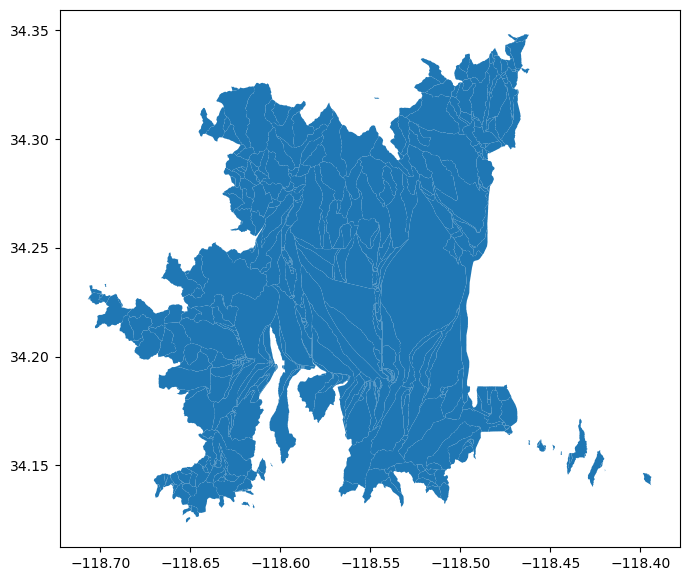

In [5]:
catchments.plot(figsize=(8, 8))

Note ``oids_bygeom`` has an additional argument for passing any valid SQL WHERE clause to further filter the data on the server side. For example, let's only keep the ones with an area of larger than 0.5 sqkm.

In [6]:
oids = hr.oids_bygeom(basin_geom, geo_crs=4326, sql_clause="AREASQKM > 0.5")
catchments = geoutils.json2geodf(hr.get_features(oids))

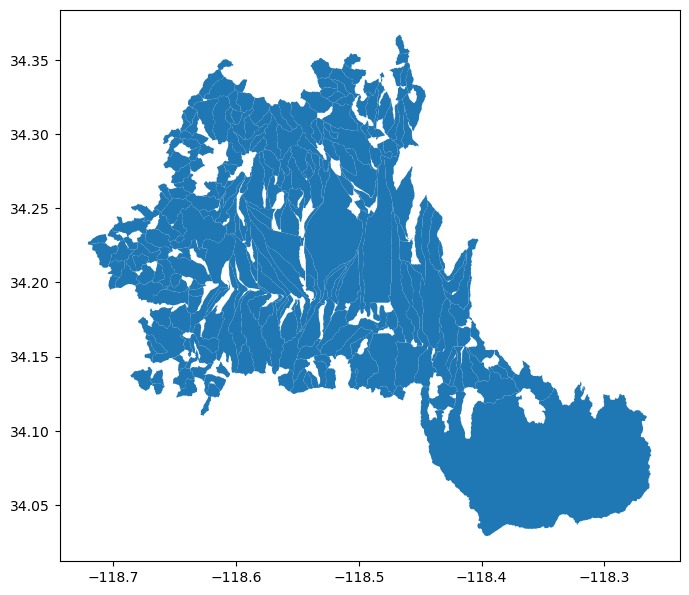

In [7]:
ax = catchments.plot(figsize=(8, 8))
ax.figure.savefig("_static/sql_clause.png", bbox_inches="tight", facecolor="w")

We can also submit a query based on IDs of any valid field in the database. If the measure
property is desired you can pass ``return_m`` as ``True`` to the ``get_features`` class method:

In [8]:
oids = hr.oids_byfield("NHDPlusID", [5000500013223, 5000400039708, 5000500004825])
resp = hr.get_features(oids, return_m=True)
catchments = geoutils.json2geodf(resp)

<Axes: >

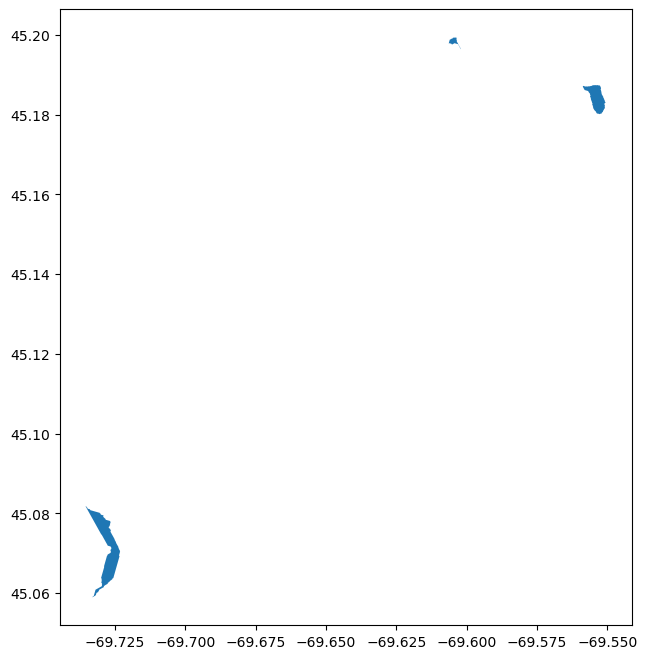

In [9]:
catchments.plot(figsize=(8, 8))

Next, let's get DEM using the [3D Elevation Program](https://www.usgs.gov/3d-elevation-program) WMS service. First we need to connect to the service using ``WMS`` class.

In [10]:
wms = WMS(
    ServiceURL().wms.nm_3dep,
    layers="3DEPElevation:None",
    outformat="image/tiff",
    crs=5070,
)

Then we can get the data using the ``getmap_bybox`` function. Note that this function only accepts a bounding box, so we need to pass a bounding box and mask the returned data later on using ``pygeoutils.gtiff2xarray`` function.

In [11]:
bbox = basin_geom.bounds
r_dict = wms.getmap_bybox(
    bbox,
    100,
    box_crs=4326,
)
dem = geoutils.gtiff2xarray(r_dict, bbox, 4326)

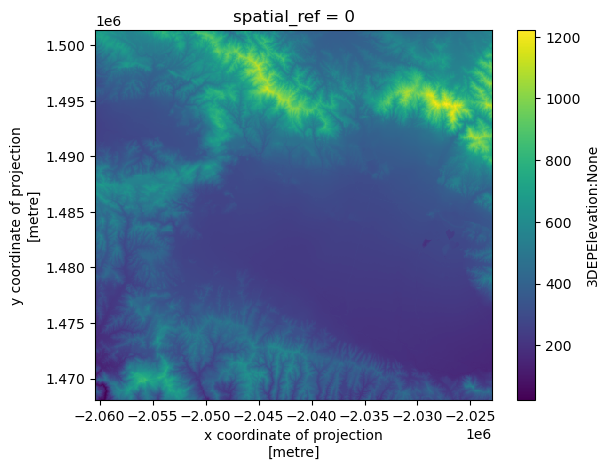

In [12]:
dem.plot()

Next, let's use WaterData service to get HUC8 using `WFS` and CQL filter.

In [13]:
layer = "wmadata:huc08"
wfs = WFS(
    ServiceURL().wfs.waterdata,
    layer=layer,
    outformat="application/json",
    version="2.0.0",
    crs=4269,
)
resp = wfs.getfeature_byfilter("huc8 LIKE '13030%'")
huc8 = geoutils.json2geodf(resp, 4269, 4326)

<Axes: >

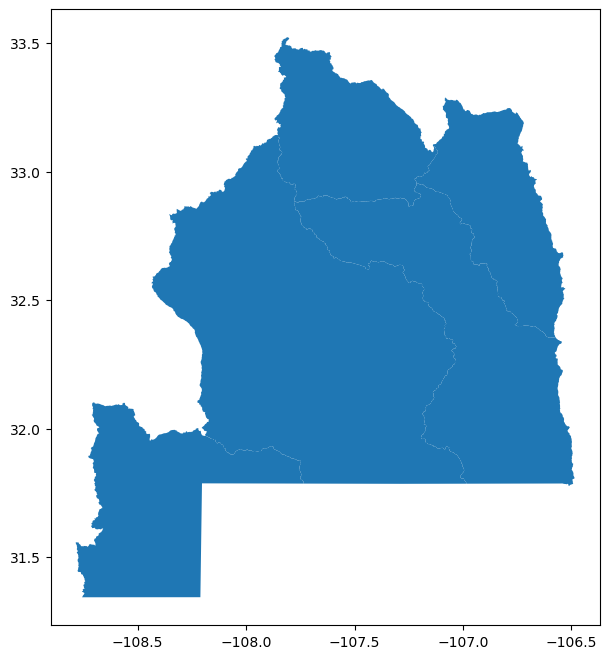

In [14]:
huc8.plot(figsize=(8, 8))